In [1]:
import os
import os.path as osp
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim
import numpy as np

from utils import process_coord, process_labels, process_samples, mask_pic

import matplotlib.pyplot as plt

In [2]:
path = '../public_data'

### Labels 

In [3]:
label_names = [file for file in os.listdir(path) if file.endswith('.json')]
label_names.sort()

In [4]:
_coord_missing, _coord_present, _pills_missing, _pills_present = process_labels(path, label_names)

In [5]:
coords = torch.from_numpy(process_coord(_coord_missing, _coord_present))

In [6]:
_masks = []
for coord in coords:
    _masks.append(mask_pic(coord))

In [7]:
masks = torch.cat(_masks)  # Quite slow

### Samples 

In [8]:
sample_names = [file for file in os.listdir(path) if file.endswith('.tiff')]
sample_names.sort()

In [9]:
_samples = process_samples(path, sample_names)

In [10]:
samples = torch.from_numpy(np.array(_samples))  # Directly casting a list of ndarrays to tensor is slower (at least for Rostyslav)

### Dataset, Dataloader 

In [11]:
class BlisterPacks(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])  # unsqueeze for the number of channels

In [12]:
blister_packs = BlisterPacks(samples, masks)
train_data, test_data = random_split(blister_packs, (round(0.8*len(blister_packs)), round(0.2*len(blister_packs))))
train_loader, test_loader = DataLoader(train_data), DataLoader(test_data)

### Unet

In [13]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
       
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.maxpool1 = nn.MaxPool2d(2, return_indices=True)

        self.conv3 = nn.Conv2d(64,128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.maxpool2 = nn.MaxPool2d(2, return_indices=True)

        self.conv5 = nn.Conv2d(128,256, 3)
        self.conv6 = nn.Conv2d(256, 256, 3)
        self.maxpool3 = nn.MaxPool2d(2, return_indices=True)

        self.conv7 = nn.Conv2d(256,512, 3)
        self.conv8 = nn.Conv2d(512, 512, 3)
        self.maxpool4 = nn.MaxPool2d(2, return_indices=True)

        self.conv9 = nn.Conv2d(512, 1024, 3)
        self.convt1 = nn.ConvTranspose2d(1024, 512, 3)
        self.maxunpool1 = nn.MaxUnpool2d(2)

        # Paper suggests using conv. I use only convsTranspose, because then the dims match. May be wrong
        self.convt2 = nn.ConvTranspose2d(1024, 512, 3)
        self.convt3 = nn.ConvTranspose2d(512, 256, 3)
        self.maxunpool2 = nn.MaxUnpool2d(2)

        self.convt4 = nn.ConvTranspose2d(512, 256, 3)
        self.convt5 = nn.ConvTranspose2d(256, 128, 3)
        self.maxunpool3 = nn.MaxUnpool2d(2)

        self.convt6 = nn.ConvTranspose2d(256, 128, 3)
        self.convt7 = nn.ConvTranspose2d(128, 64, 3)
        self.maxunpool4 = nn.MaxUnpool2d(2)

        self.convt8 = nn.ConvTranspose2d(128, 64, 3)
        self.convt9 = nn.ConvTranspose2d(64, 1, 3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Contracting path
        x1 = self.relu(self.conv1(x))  # (64, 255, 255)
        x2 = self.relu(self.conv2(x1))  # (64, 253, 253)
        x3, idcs1 = self.maxpool1(x2)  # (64, 126, 126)

        x4 = self.relu(self.conv3(x3))  # (128, 124, 124)
        x5 = self.relu(self.conv4(x4))# (128, 122, 122)
        x6, idcs2 = self.maxpool2(x5)  # (128, 61, 61)

        x7 = self.relu(self.conv5(x6))# (256, 59, 59)
        x8 = self.relu(self.conv6(x7))# (256, 57, 57)
        x9, idcs3 = self.maxpool3(x8)  # (256, 28, 28)

        x10 = self.relu(self.conv7(x9)) # (512, 26, 26)
        x11 = self.relu(self.conv8(x10)) # (512, 24, 24)
        x12, idcs4 = self.maxpool4(x11)  # (512, 12, 12)

        x13 = self.relu(self.conv9(x12)) # (1024, 10, 10)
        x14 = self.relu(self.convt1(x13))  # Up-conv  (512, 12, 12)
        # Expansive path
        x15 = self.maxunpool1(x14, indices=idcs4)  # Upsample feature map  (512, 24, 24)
        x15 = torch.cat((x11, x15), dim=0)  # Concatenate. Note, resulting variable has the same name (1024, 24, 24)

        x16 = self.relu(self.convt2(x15))  # (512, 26, 26)
        x17 = self.convt3(x16)  # (512, 28, 28)
        x18 = self.maxunpool2(x17, indices=idcs3, output_size=x8.shape[-2:])  # (512, 57, 57)
        x18 = torch.cat((x8, x18), dim=0)  # (512, 57, 57)

        x19 = self.relu(self.convt4(x18))  # (256, 59, 59)
        x20 = self.relu(self.convt5(x19))  # (128, 61, 61)
        x21 = self.maxunpool3(x20, indices=idcs2)  # (128, 122, 122)
        x21 = torch.cat((x5, x21), dim=0)  # (256, 122, 122)

        x22 = self.convt6(x21)  # (128, 124, 124)
        x23 = self.convt7(x22)  # (64, 126, 126)
        x24 = self.maxunpool4(x23, indices=idcs1, output_size=x2.shape[-2:])  # (64, 253, 253)
        x24 = torch.cat((x2, x24), dim=0)  # (128, 253, 253)

        x25 = self.relu(self.convt8(x24))  # (64, 255, 255)
        out = self.relu(self.convt9(x25))  # (1, 257, 257)
        
        return out

convmodel = Unet()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convmodel.parameters(), lr=0.01)

In [15]:
def training(data_loader):
    for data in data_loader:
        feats, labs = data
        out = convmodel(feats)
        optimizer.zero_grad()
        loss = criterion(out, labs)
        print(f'Loss: {loss:.5f}')
        print(out, out.size(), sep='\n')
        print()
        loss.backward()
        optimizer.step()
    return loss, out

In [20]:
for epoch in range(1):
    #training(train_loader)
    for data in train_loader:
        feats, labs = data
        out = convmodel(feats)
        optimizer.zero_grad()
        loss = criterion(out, labs)
        print(f'Loss: {loss:.5f}')
        print(out, out.size(), sep='\n')
        print()
        loss.backward()

Loss: 0.20779
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<ReluBackward0>)
torch.Size([1, 257, 257])

Loss: 0.29203
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<ReluBackward0>)
torch.Size([1, 257, 257])

Loss: 0.20758
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<ReluBackward0>)
torch.Size([1, 257, 257])

Loss: 0.21635
te

KeyboardInterrupt: 

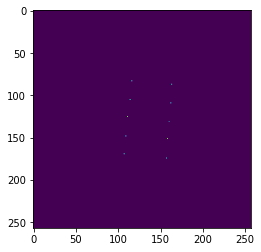

In [21]:
plt.imshow(labs.squeeze())

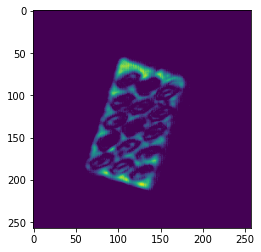

In [22]:
plt.imshow(out.squeeze().detach().numpy())

In [26]:
out.unique()

tensor([0.0000e+00, 3.1799e-05, 4.8667e-05,  ..., 7.5058e-01, 7.7104e-01,
        8.0094e-01], grad_fn=<Unique2Backward0>)

### Visualization 

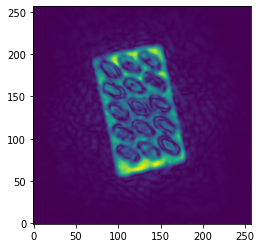

In [27]:
plt.imshow(samples[225], origin='lower')

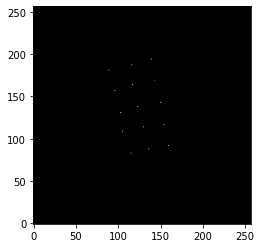

In [28]:
plt.imshow(masks[225], cmap='gray', origin='lower')

In [26]:
masks[189].unique()

tensor([0.0000, 0.5000, 1.0000])